**Making a script to input .mca or .spe files to and output some lovely spectrum**

In [4]:
filename = "abcdefg.spe"
filename[-3:]

'spe'

In [166]:
#%%writefile spectrum_reader.py
"""
spectrum_reader.py

This will read in spe or mca files from our detectors and make us some lovely background subtracted spectra


"""
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import pandas as pd

def file_type_checker(filename):
    """checks the file type, because the header will have diff formatting"""
    
    if filename[-3:] == "Spe":
        return "Spe"
    elif filename[-3:] == "mca":
        return "mca"
    else: return "error"

def file_parser(filename):

    #the function will fill and return these dictionaries:
    
    header_dict = {
        "DATE_MEAS": [],
        "MEAS_TIME": []
    }

    spectrum_dict = {
        "bins": [], 
        "counts": []
    }

    if file_type_checker(filename) == "Spe" :
        IS_DATA = False

        with open(filename, "r") as file:
            for line in file:
                line = line.strip()

            # if it's data, reset the flag
                if line == '$DATA:':
                    IS_DATA = True
                    continue
                elif line.startswith('$MEAS_TIM:'):
                    next_line = next(file).split(" ")
                    header_dict["MEAS_TIME"].append(float(next_line[0]))
                    IS_DATA = False
                elif line.startswith('$DATE_MEA:'):
                    next_line = next(file).strip()
                    header_dict["DATE_MEAS"].append(next_line)
                    IS_DATA = False

            #this is for all lines following # DATA
            #while IS_DATA == True:  
                if IS_DATA == True:
                    try:
                        spectrum_dict["counts"].append(float(line))
                    except ValueError:
                        continue   
        #change if bin range changes
        for i in range(len(spectrum_dict["counts"])):
            spectrum_dict["bins"].append(i)
        
        return header_dict, spectrum_dict

    elif  file_type_checker(filename) == "mca" :
        IS_DATA = False

        with open(filename, "r") as file:
            for line in file:
                line = line.strip()
    
                # if it's data, reset the flag
                if line.startswith('<<DATA>>'):
                    IS_DATA = True
                    continue
                elif line.startswith('REAL_TIME'):
                    line = line.strip()
                    header_dict["MEAS_TIME"].append(float(line[12:]))
                    IS_DATA = False
                elif line.startswith('START_TIME'):
                    line = line.strip()
                    header_dict["DATE_MEAS"].append(line[13:])
                    IS_DATA = False
                elif line.startswith("<<END>>"):
                    IS_DATA = False
                # else:
                #     print('hang on a sec')
                #     print(line)
    
                #this is for all lines following # DATA
                #while IS_DATA == True:  
                if IS_DATA == True:
                    try:
                        spectrum_dict["counts"].append(int(line))
                    except Exception as e:
                        print(e)
                        continue   
        #change if bin range changes
        for i in range(len(spectrum_dict["counts"])):
            spectrum_dict["bins"].append(i)
        
        return header_dict, spectrum_dict

    elif file_type_checker(filename) == "error":
        print("give me the right file type (mca or spe) pretty please!")

def background_subtract(data, background):
    """
    Converts soectrum to units of counts/sec then subtracts background from data
    Inputs: data file, backgound file (.spe or .mca files)
    Outputs: returns dataframe object of bins and counts per second of background subtracted spectra and plot of bins by counts/sec
    """
    data_header, data_spectrum = file_parser(data)
    background_header, background_spectrum = file_parser(background)

    background_ct = background_header["MEAS_TIME"]
    data_ct = data_header["MEAS_TIME"]

    background_subtracted = (np.array(data_spectrum["counts"]) / data_ct) - (np.array(background_spectrum["counts"]) / background_ct)

    table = {
        'bins' : data_spectrum["bins"],
        'counts/sec' : background_subtracted
    }

    plt.close("all")
    fig, ax = plt.subplots(figsize = (8,8))
    ax.set_title(f"background subtracted spectra from: {data}")
    ax.set_xlabel("bins")
    ax.set_ylabel("counts / sec")
    ax.scatter(table["bins"], table["counts/sec"], s = 1, label = "Spectrum")

    ax.legend()
    plt.show()
    
    return pd.DataFrame(table)

def peak_finder(table):
    """finds peaks in data"""

    max_point = np.argmax(table["counts/sec"][10:]) #ignores the first ten bins incase of weird detector noise
    
    return int(max_point)

def ignore_peak(flux):
    """
    Function used to ignore the peak part of the data for plotting the baseline
    Input: y data (flux)
    Output: list of ajdusted y data, were values associated with the peak are replaced with mean flux
    """
    background_y = []
    mean_flux = np.mean(flux)
    flux_std = np.std(flux)
    for i in flux:
        if i > 1 : #0.5 * (flux_std): #if the flux is higher than this, the point is probably part of the peak
            background_y.append(mean_flux)
        else:
            background_y.append(i)
    return background_y

#fitting functions: 
def quadratic(x, a, b, c):
    """A quatratic function, used for curve fitting"""
    return a * (x**2) + b * x + c

def gaussian(x, mu, sig, amp):
    """A Gaussian function, used for scipi curve fit"""
    return amp * np.exp(-0.5 * (x-mu)**2 / sig**2) / np.sqrt(2 * np.pi * sig**2)

def compound_model(x, mu, sig, amp, a, b, c):
    """combines the quadratic fit of the background with the Gaussian fit which better represents the peak"""
    return quadratic(x, a, b, c) + gaussian(x, mu, sig, amp)

def fit_compound_model(x, y, p0=None):
    """
    Function to fit data using curve_fit and compound_model
    Inputs: x, y (list of x, y data)
    Outputs: popt (parameters array), pcov (covarience array) 
    """

    #if no p0 is passed, guess: 

    if p0 is None: 
        A_guess = np.max(y) - np.min(y)
        mu_guess = np.sum(x * y) / np.sum(y)
        sigma_guess = (np.max(x) - np.min(x)) / 10
        #getting the polynomial parameters: 
        background_y = ignore_peak(y)
        b_popt, b_pcov = curve_fit(quadratic, x, background_y, p0 = None)

    p0 = [mu_guess, sigma_guess, A_guess, *b_popt]
    popt, pcov = curve_fit(compound_model, x, y, p0 = p0)

    return popt, pcov

def print_uncertainties(pcov, popt):
    """a function to print out the parameters and their uncertanties"""
    uncertainties = np.sqrt(np.diag(pcov))
    #[mu0, sig0, amp0, a, b, c] 
    print("Parameters: \n")
    print(f"Baseline Polynomial Fit: ")
    print(f"a = {popt[3]} +/- {uncertainties[3]},")
    print(f"b = {popt[4]} +/- {uncertainties[4]}, ")
    print(f"c = {popt[5]} +/- {uncertainties[5]}")
    print(f"Gaussian Fit: ")
    print(f"mu0 = {popt[0]} +/- {uncertainties[0]},")
    print(f"sigma0 = {popt[1]} +/- {uncertainties[1]},")
    print(f"amp0 = {popt[2]} +/- {uncertainties[2]}")

def gauss_fitter(table, peak_range):
    """
    Function to fit a gaussian to data and find the location of peaks
    Input: table of bins and counts/sec for a spectrum and a range of interest to look for peaks in
    Output: mu0 (popt[0] from the curve fit of a found peak), and some plots
    """
    
    
    background_y = ignore_peak(table["counts/sec"][peak_range])
    b_popt, b_pcov = curve_fit(quadratic, table["bins"][peak_range], background_y, p0 = None)
    quad_fit = quadratic(np.array(table["bins"][peak_range]), *b_popt)

    #plotting data with polynomial baseline fit overlaid:
    plt.close("all")
    fig, ax = plt.subplots(figsize  = (9,6))
    ax.set_title("Spectrum Data Plotted With Baseline Fitted")
    ax.set_xlabel("bins")
    ax.set_ylabel("counts per second")
    
    ax.plot(table["bins"][peak_range], table["counts/sec"][peak_range], ls = ":", label = "data")
    ax.plot(table["bins"][peak_range], quad_fit, ls = '--', label = "fit")
    ax.grid()
    ax.legend()
    plt.show()

    #fitting and plotting gauss model: 
    popt, pcov = fit_compound_model(np.array(table["bins"][peak_range]), np.array(table["counts/sec"][peak_range]))
    #compound_fit = compound_model(np.array(spectrum_dict["Wavelength"]), *popt)
    gauss_fit = gaussian(np.array(table["bins"][peak_range]), *popt[:3])
        
    fig, ax = plt.subplots(figsize = (9,6))
    
    ax.set_title("Spectrum Data Plotted With Gaussian Fit: Second Peak from the Left")
    ax.set_xlabel("bins")
    ax.set_ylabel("counts per second")
    
    ax.plot(table["bins"][peak_range], table["counts/sec"][peak_range], ls = ":", label = "data")
    ax.plot(table["bins"][peak_range], quad_fit, ls = '--', label = "baseline fit")
    #for some reason the line below works better than plotting compound model even though it should return the same thing?
    ax.plot(table["bins"][peak_range], gauss_fit + quad_fit, ls = '-', color = 'r', label = "gaussian fit") 
    ax.grid()
    ax.legend()
    plt.show()
    
    #printing out parameters and uncertainties:
    print_uncertainties(pcov, popt)

    return popt[0]



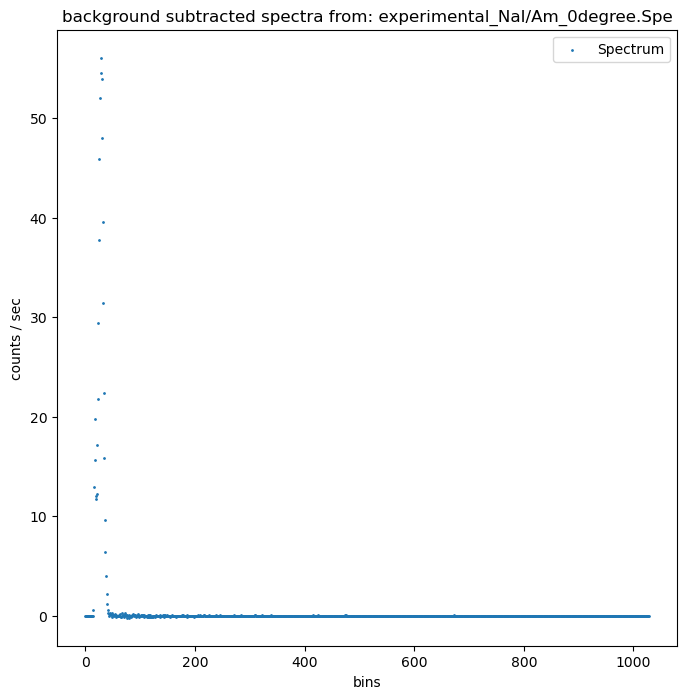

In [145]:
bg_sub_table = background_subtract("experimental_NaI/Am_0degree.Spe", "experimental_NaI/Buffer_Data.Spe")

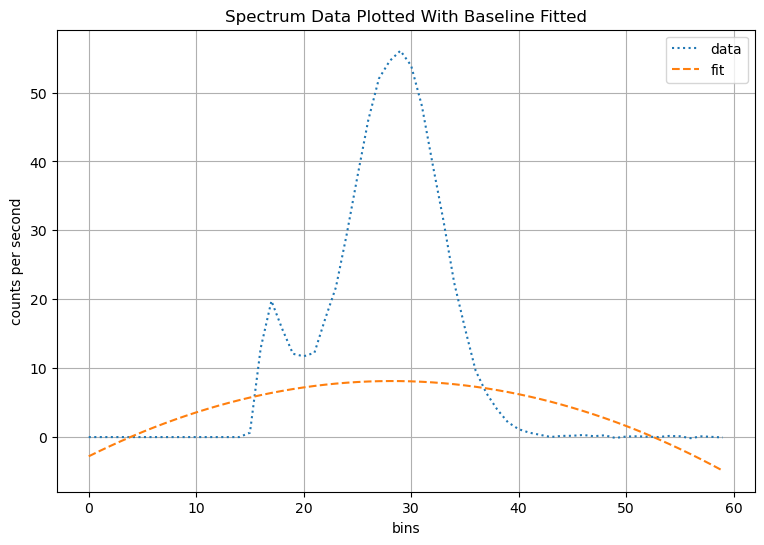

Parameters: 

Baseline Polynomial Fit: 
a = -0.00571342134663636 +/- 0.002388264361939577,
b = 0.29683276256423935 +/- 0.14221888889538942, 
c = -0.1237294509414419 +/- 1.3713750946491865
Gaussian Fit: 
mu0 = 28.49689984267721 +/- 0.1408286438023175,
sigma0 = -3.9824018459860997 +/- 0.17792752816107382,
amp0 = 519.8481850081212 +/- 28.33496837262808


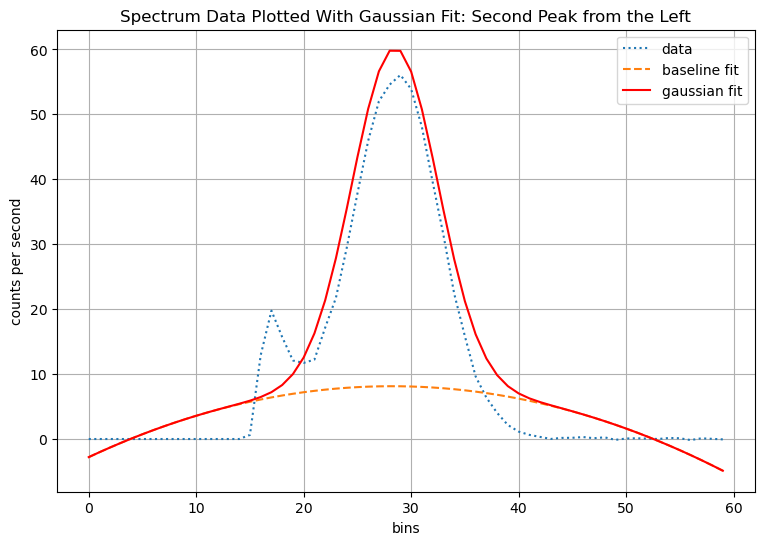

In [147]:
mu0 = gauss_fitter(bg_sub_table, range(0,60))

In [148]:
#location of peak found: 
mu0

np.float64(28.49689984267721)

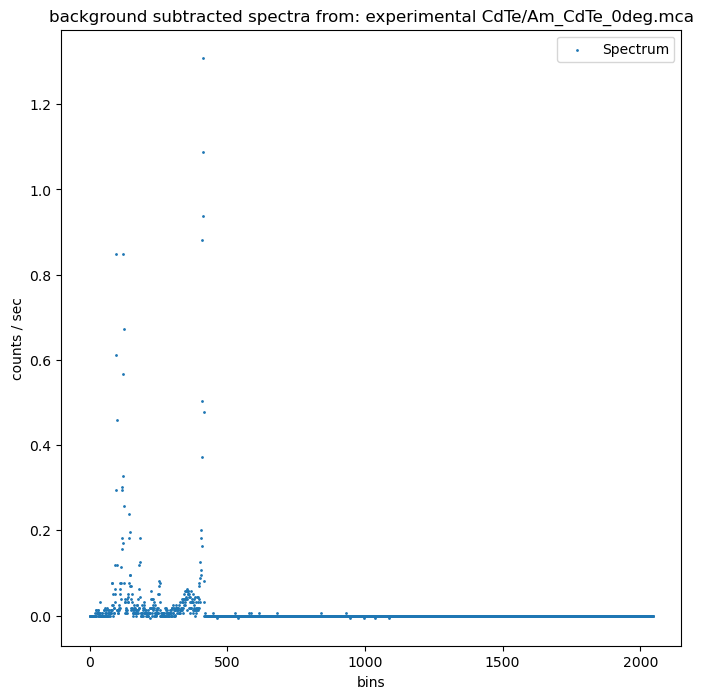

In [149]:
bg_sub_table = background_subtract("experimental CdTe/Am_CdTe_0deg.mca", "experimental CdTe/Background_CdTe.mca")

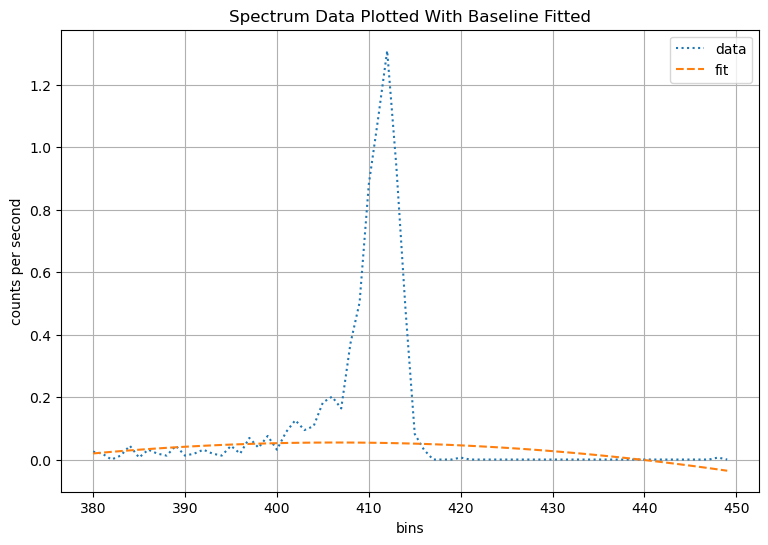

Parameters: 

Baseline Polynomial Fit: 
a = -3.056888640333986e-05 +/- 1.7892145063425757e-05,
b = 0.02451444606439021 +/- 0.01482726576930898, 
c = -4.871814730319412 +/- 3.064631002586424
Gaussian Fit: 
mu0 = 411.4745177450784 +/- 0.05869155888473585,
sigma0 = -1.8205880661473053 +/- 0.0626051521537786,
amp0 = 5.501236083205811 +/- 0.18346730178423692


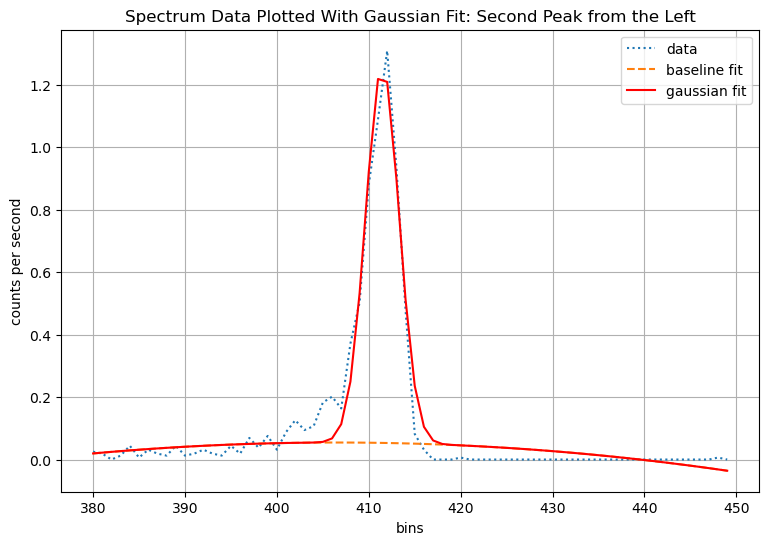

In [151]:
mu0 = gauss_fitter(bg_sub_table, range(380, 450))

In [152]:
#location of found peak: 
mu0

np.float64(411.4745177450784)

In [143]:
#can just specify ROI with script 

**make congifuration files for script to read:**

am.txt for example:
in files have:
1. ROIs for peak(s)
2. corrensponding energies for peak(s) (E in keV)

create as yaml files (yet another markup language)

setup the yaml, which makes dictionaries

roi:
    \tab CdTe:
        \tabrange
    \tab BGO:
        \tab range
Energy:
    \tab CdTe:
        \tab energy




**Calibration for NaITI detector**

In [193]:
#making table of peak energies (wiht largest emission fraction(s) ):

energies = {
    'Co' : [1173.228, 1332.492],
    'Cs': [661.657],
    'Ba': [80.9979, 356.0129],
    'Am': [59.5409]
}

In [194]:
Am = "experimental_NaI/Am_0degree.Spe"
Cs = "experimental_NaI/Cs_0degree.Spe"
Co = "experimental_NaI/Co_0degree.Spe"
Ba = "experimental_NaI/Ba_0degree.Spe"

bg = "experimental_NaI/Buffer_Data.Spe"

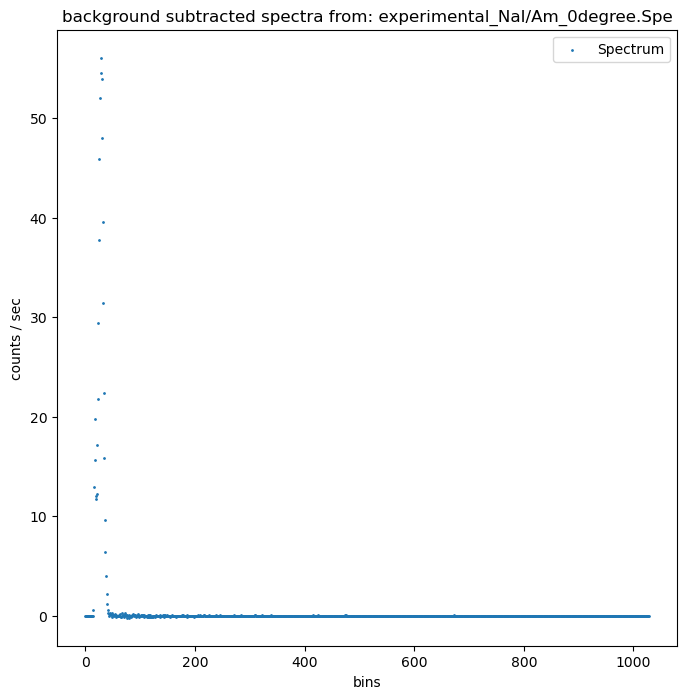

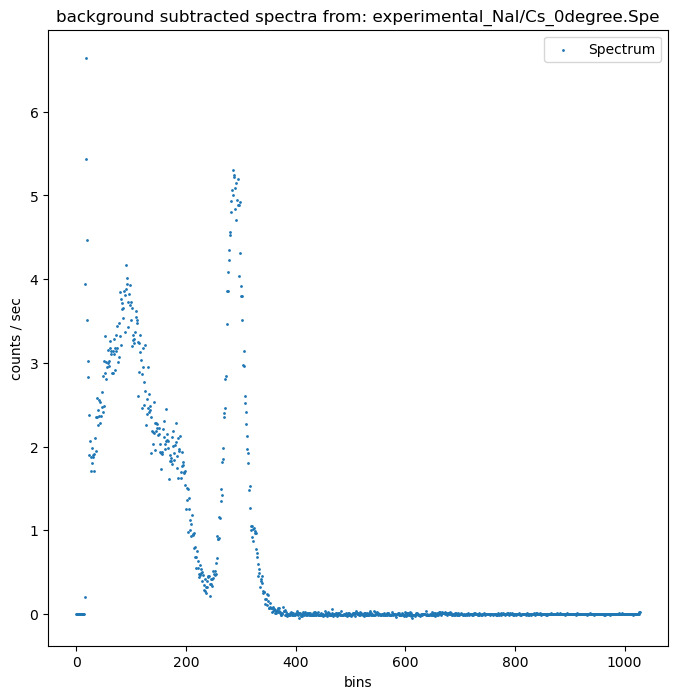

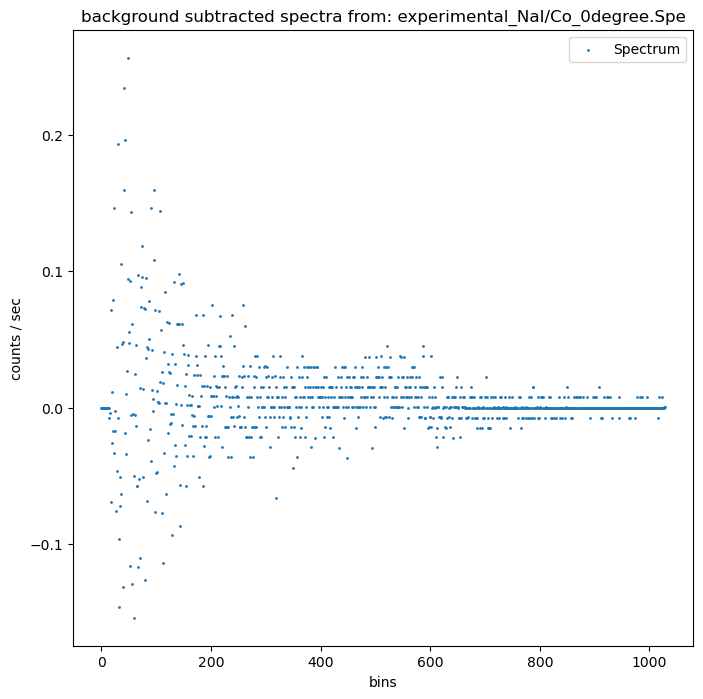

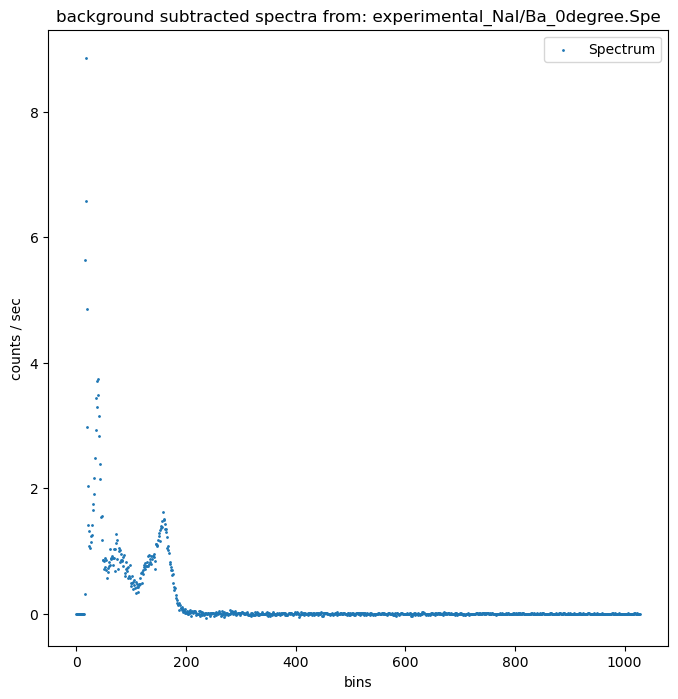

In [195]:
Am_sub_table =  background_subtract(Am, bg)
Cs_sub_table =  background_subtract(Cs, bg)
Co_sub_table =  background_subtract(Co, bg)
Ba_sub_table =  background_subtract(Ba, bg)

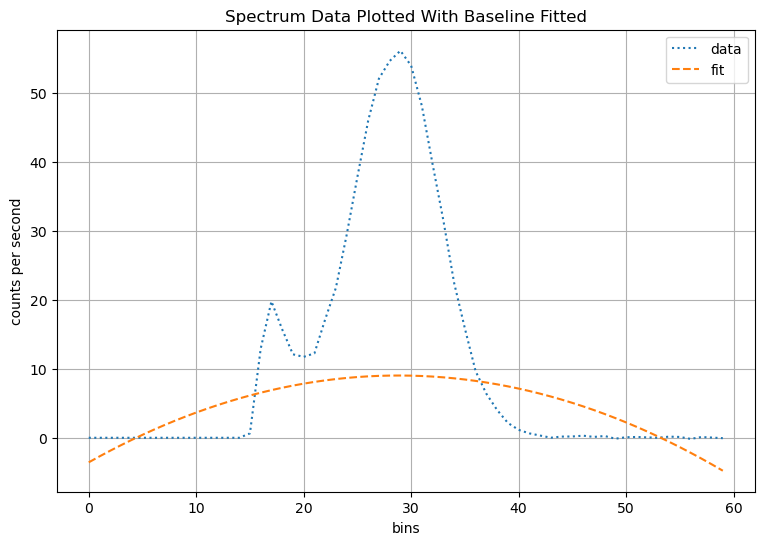

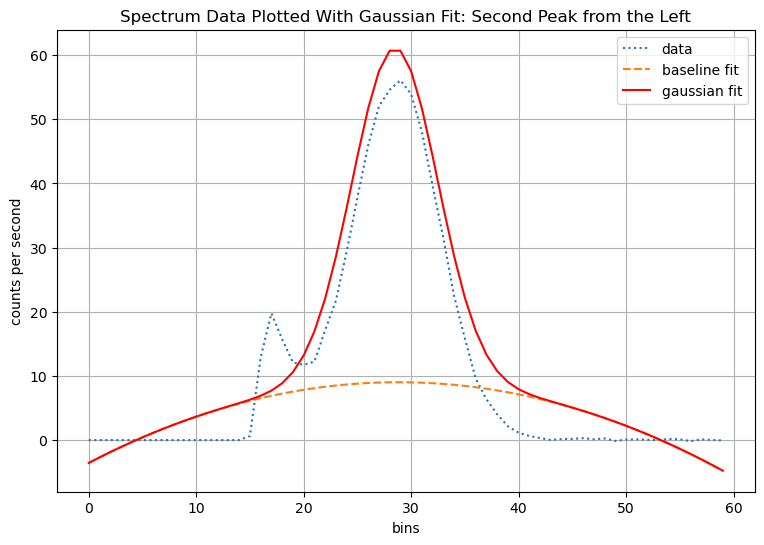

Parameters: 

Baseline Polynomial Fit: 
a = -0.005712890867418806 +/- 0.002388344615781205,
b = 0.2968029370852544 +/- 0.14222333813494809, 
c = -0.12362423612666153 +/- 1.3713826133335851
Gaussian Fit: 
mu0 = 28.496865086446352 +/- 0.14083378166829424,
sigma0 = -3.982477676255817 +/- 0.17793789273508195,
amp0 = 519.857447353207 +/- 28.337229016263727


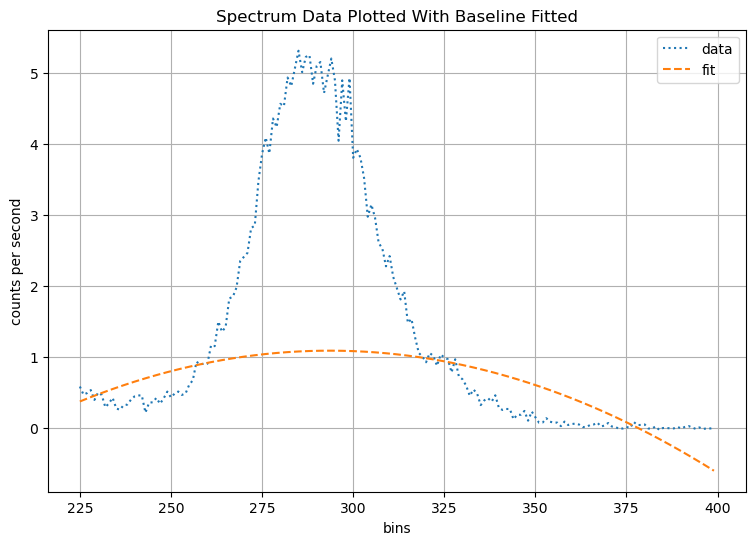

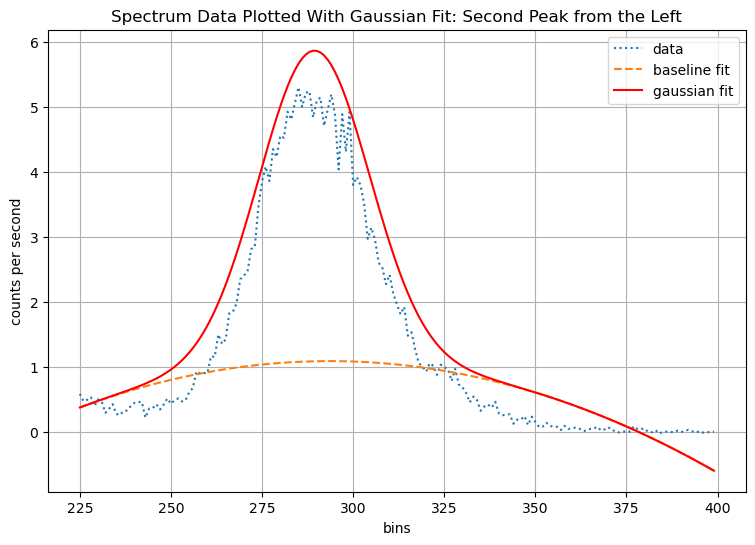

Parameters: 

Baseline Polynomial Fit: 
a = -3.782207188024134e-05 +/- 7.9251789282774e-06,
b = 0.021181996820871112 +/- 0.004863607891223049, 
c = -2.5511703385185562 +/- 0.7179221272987707
Gaussian Fit: 
mu0 = 289.31654474714514 +/- 0.15659347756185862,
sigma0 = -15.060011235079358 +/- 0.19868838567967342,
amp0 = 180.72637632464213 +/- 3.0892199979551713


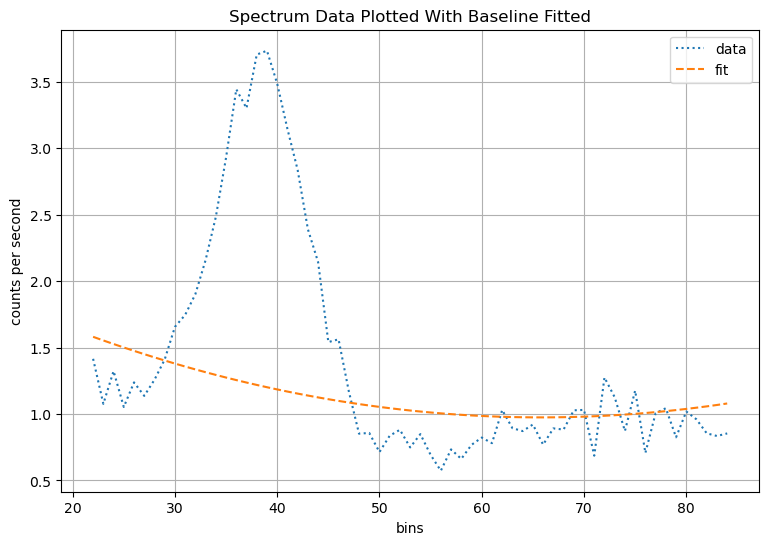

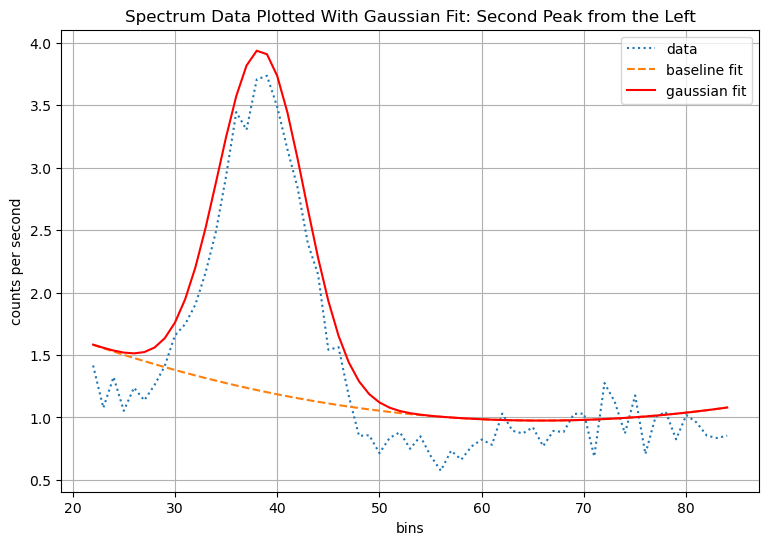

Parameters: 

Baseline Polynomial Fit: 
a = 0.00034353614886282113 +/- 6.479706912222512e-05,
b = -0.03983418817744932 +/- 0.006864691591349127, 
c = 1.9625936531613142 +/- 0.17027994160867985
Gaussian Fit: 
mu0 = 38.428374238791356 +/- 0.12039129401152256,
sigma0 = 4.240075232750243 +/- 0.13916770216565527,
amp0 = 29.01321226051644 +/- 1.079686064267368


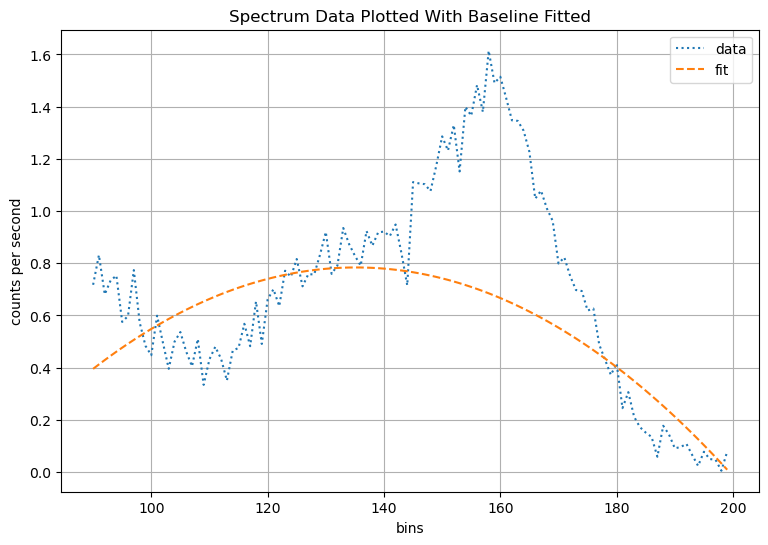

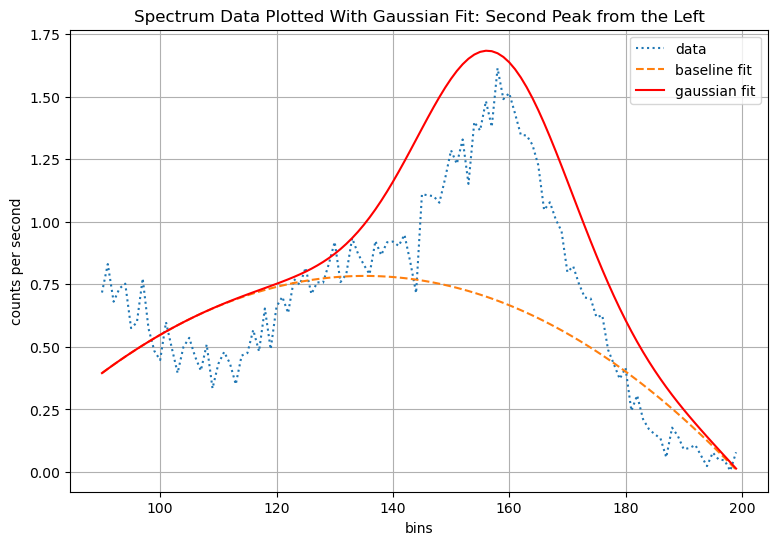

Parameters: 

Baseline Polynomial Fit: 
a = -7.806265488227428e-05 +/- 2.214222400110456e-05,
b = 0.016852338039337052 +/- 0.006633742400256942, 
c = -0.3115749193111016 +/- 0.45481343641593885
Gaussian Fit: 
mu0 = 157.52785982886067 +/- 0.5233425339553044,
sigma0 = 12.672656983164178 +/- 0.7596530620969801,
amp0 = 31.453902007491063 +/- 2.938851568221126


In [196]:
Am_peak = gauss_fitter(Am_sub_table, range(0,60))
Cs_peak = gauss_fitter(Cs_sub_table, range(225, 400))
Ba_peak_1 = gauss_fitter(Ba_sub_table, range(22, 85))
Ba_peak_2 = gauss_fitter(Ba_sub_table, range(90,200))

In [197]:
print(Am_peak)
print(Cs_peak)
print(Ba_peak_1)
print(Ba_peak_2)

28.496865086446352
289.31654474714514
38.428374238791356
157.52785982886067


In [198]:
NaITi_table = {
    'channel': [Am_peak, Cs_peak, Ba_peak_1, Ba_peak_2],
    'energy': [energies["Am"][0], energies["Cs"][0], energies["Ba"][0], energies["Ba"][1]]
}

In [199]:
NaITi = pd.DataFrame(NaITi_table)
NaITi

,channel,energy
0,28.496865,59.5409
1,289.316545,661.6570
2,38.428374,80.9979
3,157.527860,356.0129


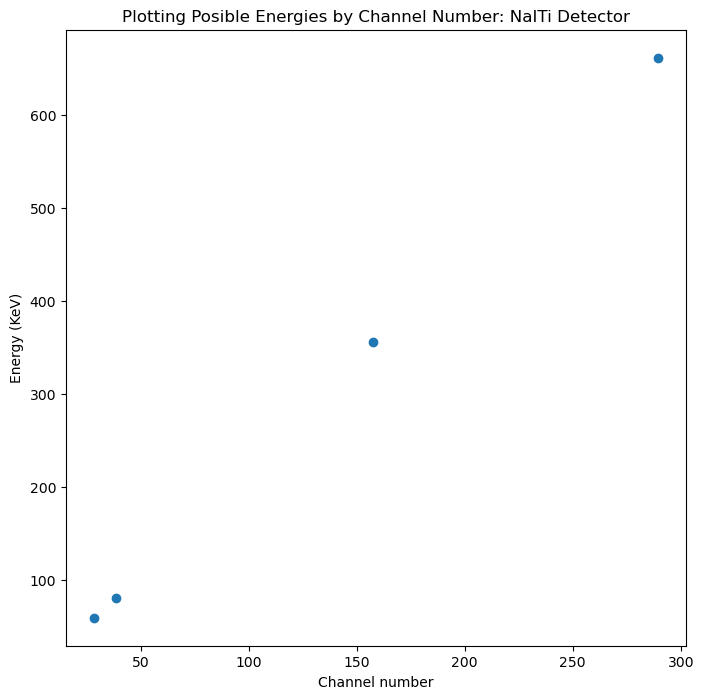

In [175]:
plt.close("all")
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title("Plotting Posible Energies by Channel Number: NaITi Detector")
ax.set_xlabel("Channel number")
ax.set_ylabel("Energy (KeV)")
ax.scatter(NaITi_table['channel'], NaITi_table['energy'])

plt.show()

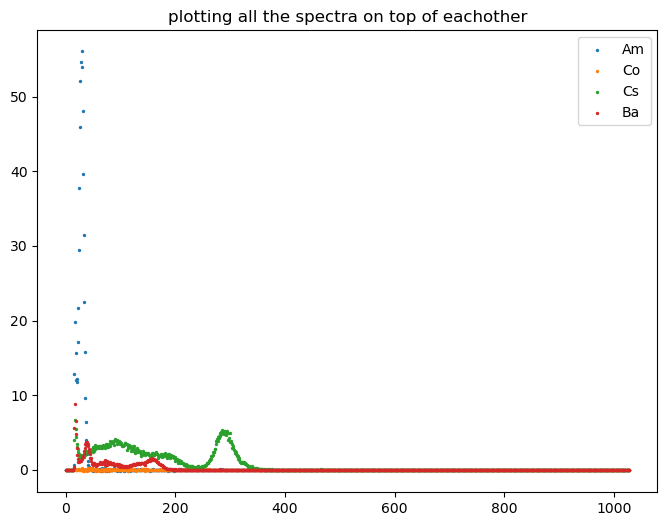

In [201]:
#Plotting all the spectra at once: 

fig, ax = plt.subplots(figsize = (8,6))
ax.set_title("plotting all the spectra on top of eachother")
ax.scatter(Am_sub_table["bins"], Am_sub_table["counts/sec"], s = 2, label = "Am")
ax.scatter(Co_sub_table["bins"], Co_sub_table["counts/sec"], s = 2, label = "Co")
ax.scatter(Cs_sub_table["bins"], Cs_sub_table["counts/sec"], s = 2, label = "Cs")
ax.scatter(Ba_sub_table["bins"], Ba_sub_table["counts/sec"], s = 2, label = "Ba")

ax.legend()
plt.show()

In [176]:
from lmfit.models import LinearModel

line = LinearModel()

def model_fit_and_plot(xdata, ydata, title, model=LinearModel()):
    '''
    Fit a line or curve, and plot/show the fit results.
    The function returns a parameters object with the fit parameters
    '''
    params = model.make_params()
    model_fit = model.fit(ydata, params, x=xdata)
    model_fit.plot()
    plt.title(f'Fitting a line to {title}')
    plt.ylabel("Detector Bin")
    plt.xlabel("Peak Energy (KeV)")
    plt.scatter(xdata, ydata, marker = '.', label = 'Data')
    plt.legend()
    print(model_fit.fit_report())
    # Complete the function
    return model_fit.params

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 4
    # variables        = 2
    chi-square         = 1.87925945
    reduced chi-square = 0.93962973
    Akaike info crit   = 0.97833372
    Bayesian info crit = -0.24907755
    R-squared          = 0.99999215
[[Variables]]
    slope:      2.31059596 +/- 0.00457880 (0.20%) (init = 1)
    intercept: -7.22634139 +/- 0.76209142 (10.55%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.7717


name,value,standard error,relative error,initial value,min,max,vary
slope,2.31059596,0.00457880,(0.20%),1.0,-inf,inf,True
intercept,-7.22634139,0.76209142,(10.55%),0.0,-inf,inf,True


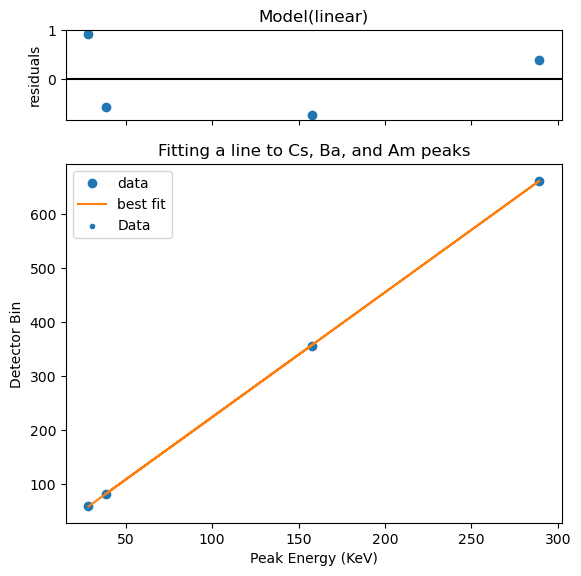

In [177]:
model_fit_and_plot(NaITi_table['channel'], NaITi_table['energy'], "Cs, Ba, and Am peaks")

In [178]:
#no Cobalt peaks because fuck Cobalt

**Calibration for CdTe Detector**

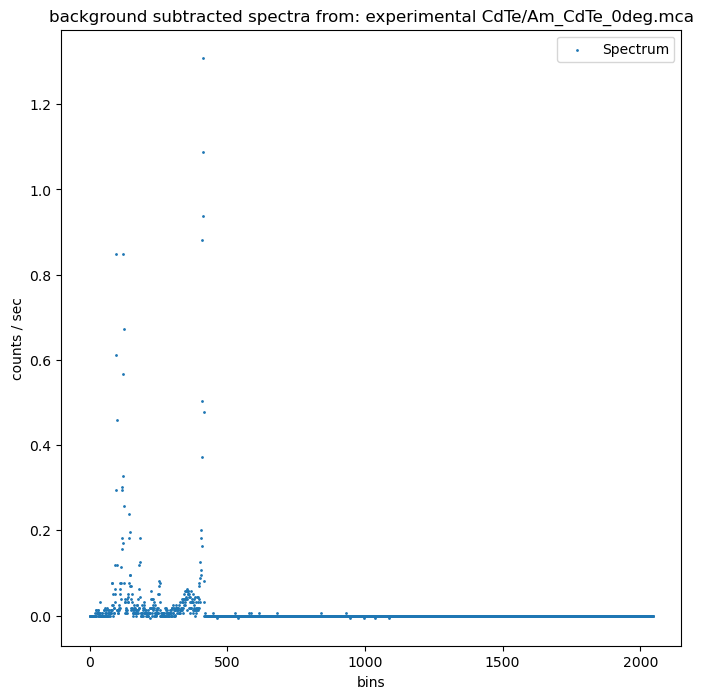

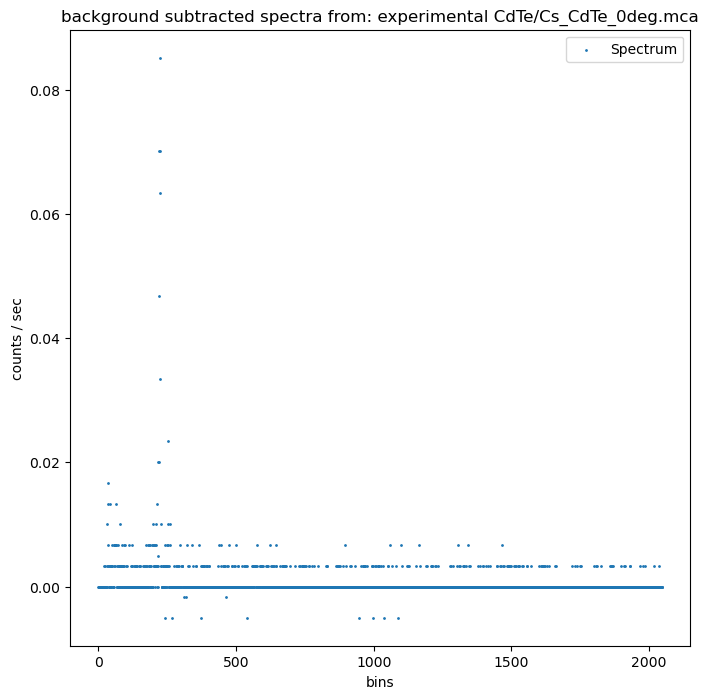

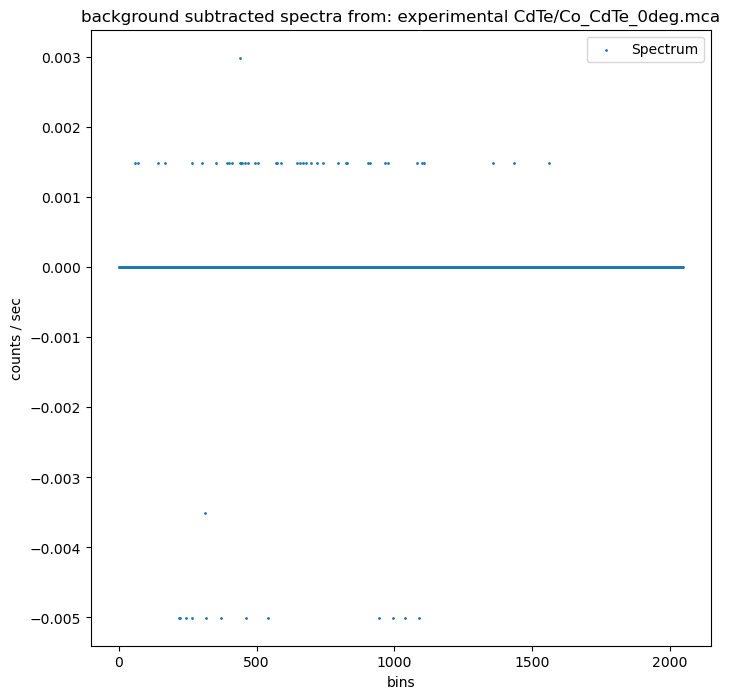

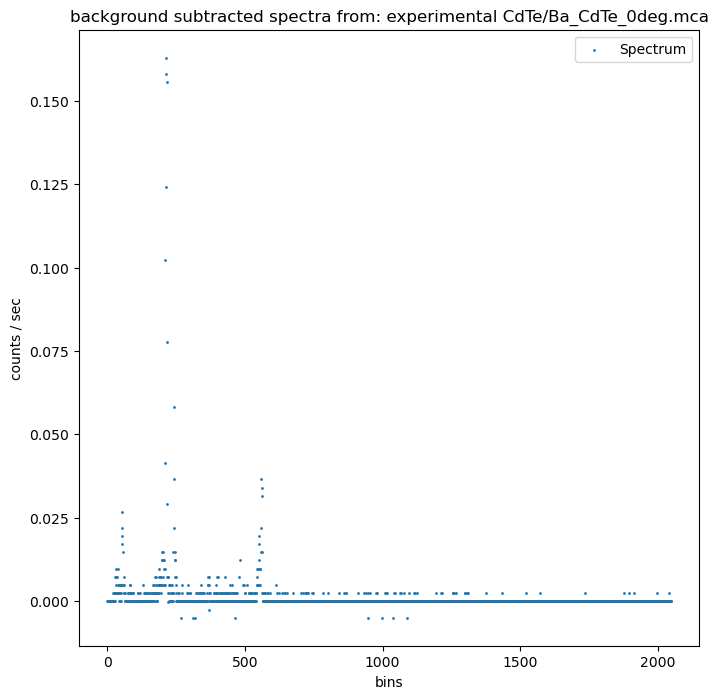

In [179]:
Am = "experimental CdTe/Am_CdTe_0deg.mca"
Cs = "experimental CdTe/Cs_CdTe_0deg.mca"
Co = "experimental CdTe/Co_CdTe_0deg.mca"
Ba = "experimental CdTe/Ba_CdTe_0deg.mca"

bg = "experimental CdTe/Background_CdTe.mca"

Am_sub_table =  background_subtract(Am, bg)
Cs_sub_table =  background_subtract(Cs, bg)
Co_sub_table =  background_subtract(Co, bg)
Ba_sub_table =  background_subtract(Ba, bg)

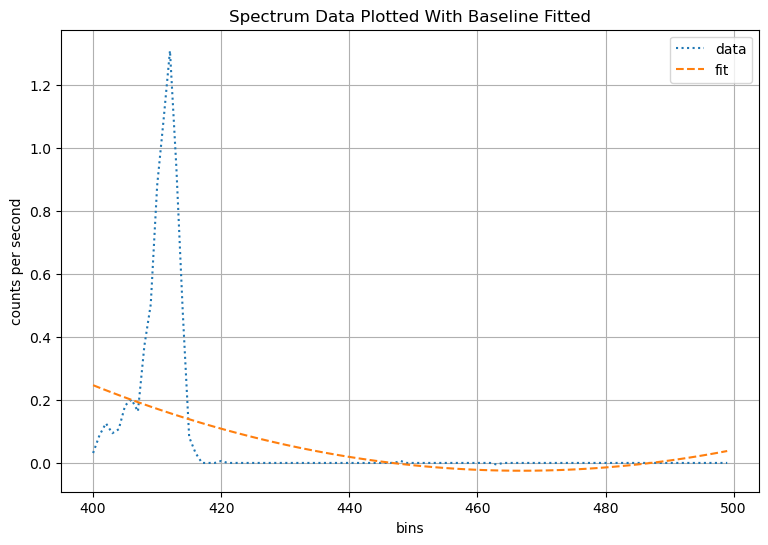

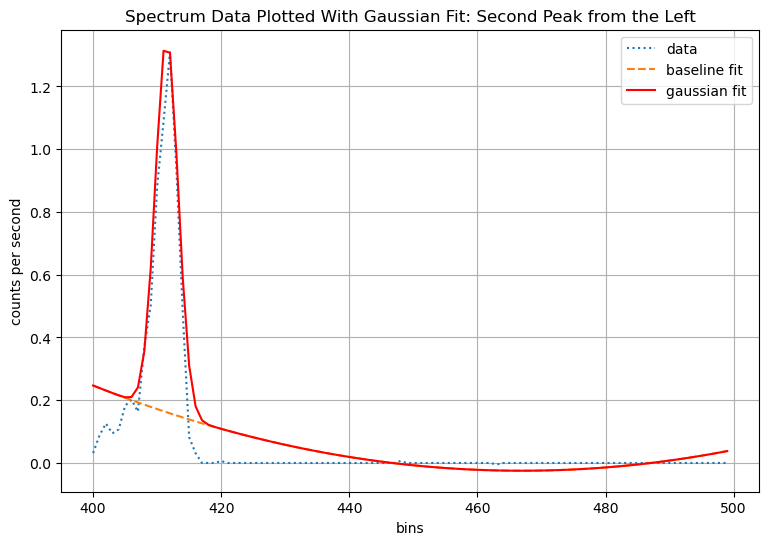

Parameters: 

Baseline Polynomial Fit: 
a = 2.6677121064999943e-05 +/- 5.066032390520494e-06,
b = -0.024700132508382315 +/- 0.004574824831015641, 
c = 5.704030948750426 +/- 1.029938193093365
Gaussian Fit: 
mu0 = 411.5005439928006 +/- 0.04269198934656482,
sigma0 = -1.774519087576645 +/- 0.04585763290905786,
amp0 = 5.318167210510555 +/- 0.1343366391892496


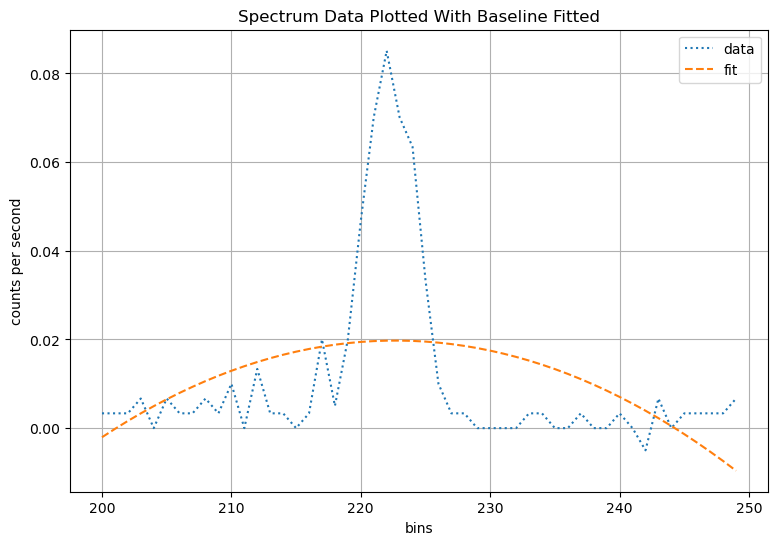

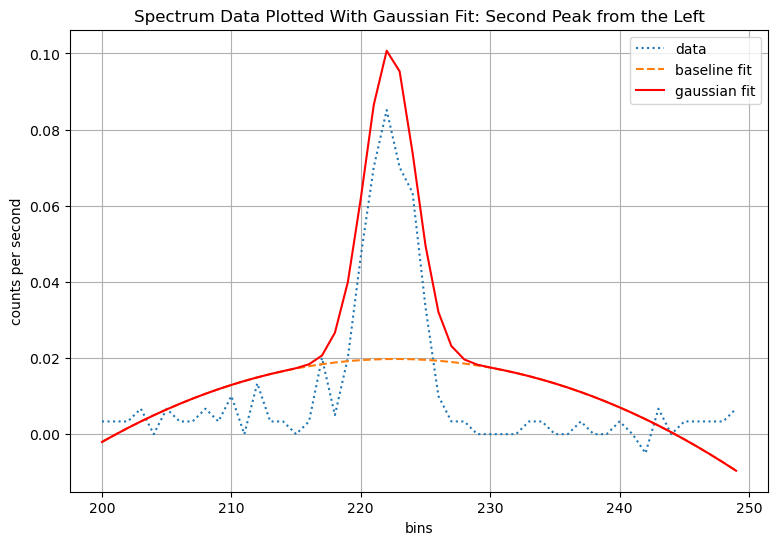

Parameters: 

Baseline Polynomial Fit: 
a = 3.6215178064293364e-06 +/- 3.7524467595520535e-06,
b = -0.0016931774618193856 +/- 0.001683331198328963, 
c = 0.1996225447178864 +/- 0.18792576672607977
Gaussian Fit: 
mu0 = 222.23473556173442 +/- 0.07609319466562851,
sigma0 = -1.9558204248882547 +/- 0.08474664648222195,
amp0 = 0.3999507995884651 +/- 0.01794889600519253


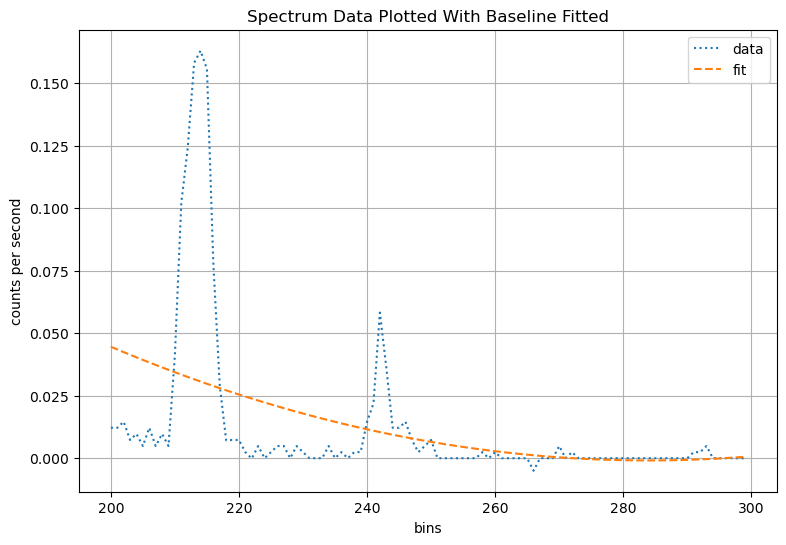

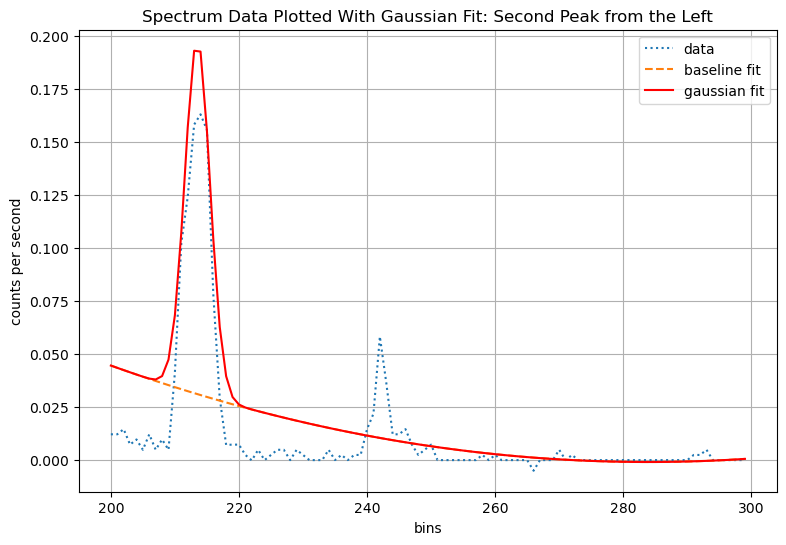

Parameters: 

Baseline Polynomial Fit: 
a = -4.5037861845344284e-07 +/- 1.1930617426644582e-06,
b = 0.00013591573701246732 +/- 0.0005997798533152148, 
c = -0.0016006365034672277 +/- 0.07471219700032965
Gaussian Fit: 
mu0 = 213.51212662286036 +/- 0.07708879326847834,
sigma0 = 1.9673395835374694 +/- 0.08241010393726715,
amp0 = 0.8231723583359546 +/- 0.03350815098276417


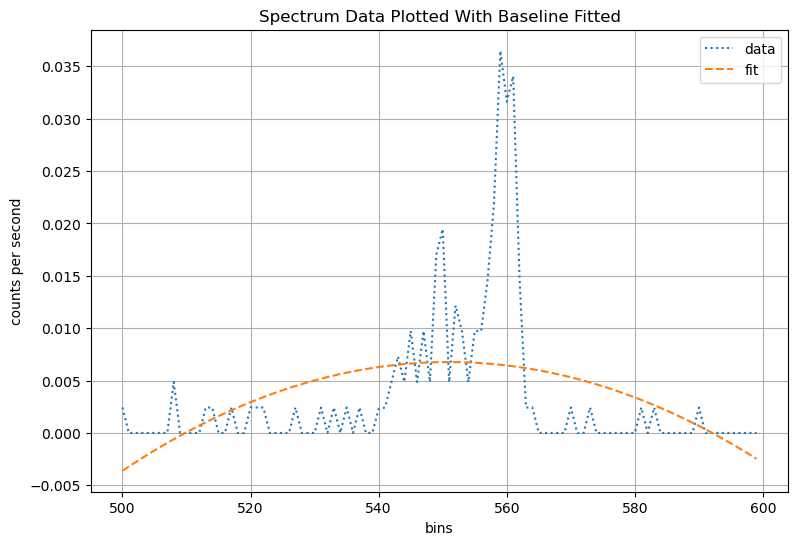

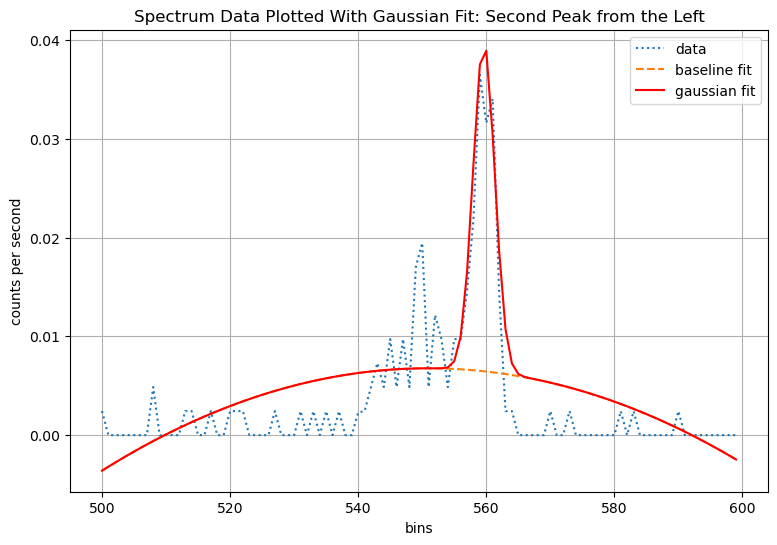

Parameters: 

Baseline Polynomial Fit: 
a = -2.1501570032916446e-06 +/- 4.712513148164292e-07,
b = 0.0023573543129297592 +/- 0.0005184469688716354, 
c = -0.6423160666219979 +/- 0.14223747450045973
Gaussian Fit: 
mu0 = 559.6307235907096 +/- 0.1387450523037081,
sigma0 = 1.690483517006766 +/- 0.14382812898843686,
amp0 = 0.14098022153566486 +/- 0.011101909520193947


In [187]:
Am_peak = gauss_fitter(Am_sub_table, range(400,500))
Cs_peak = gauss_fitter(Cs_sub_table, range(200, 250))
Ba_peak_1 = gauss_fitter(Ba_sub_table, range(200, 300))
Ba_peak_2 = gauss_fitter(Ba_sub_table, range(500,600))

In [184]:
CdTe_table = {
    'channel': [Am_peak, Cs_peak, Ba_peak_1, Ba_peak_2],
    'energy': [energies["Am"][0], energies["Cs"][0], energies["Ba"][0], energies["Ba"][1]]
}

In [189]:
CdTe = pd.DataFrame(CdTe_table)
CdTe

,channel,energy
0,411.500544,59.5409
1,222.231077,661.6570
2,213.512127,80.9979
3,559.630724,356.0129


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 4
    # variables        = 2
    chi-square         = 234777.097
    reduced chi-square = 117388.549
    Akaike info crit   = 47.9203898
    Bayesian info crit = 46.6929786
    R-squared          = 0.01881486
[[Variables]]
    slope:     -0.23336224 +/- 1.19162752 (510.63%) (init = 1)
    intercept:  371.630018 +/- 452.776642 (121.84%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9257


name,value,standard error,relative error,initial value,min,max,vary
slope,-0.23336224,1.19162752,(510.63%),1.0,-inf,inf,True
intercept,371.630018,452.776642,(121.84%),0.0,-inf,inf,True


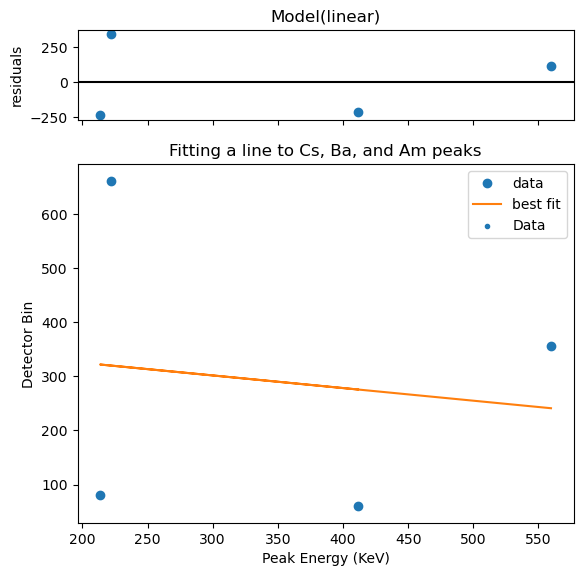

In [185]:
model_fit_and_plot(CdTe_table['channel'], CdTe_table['energy'], "Cs, Ba, and Am peaks")

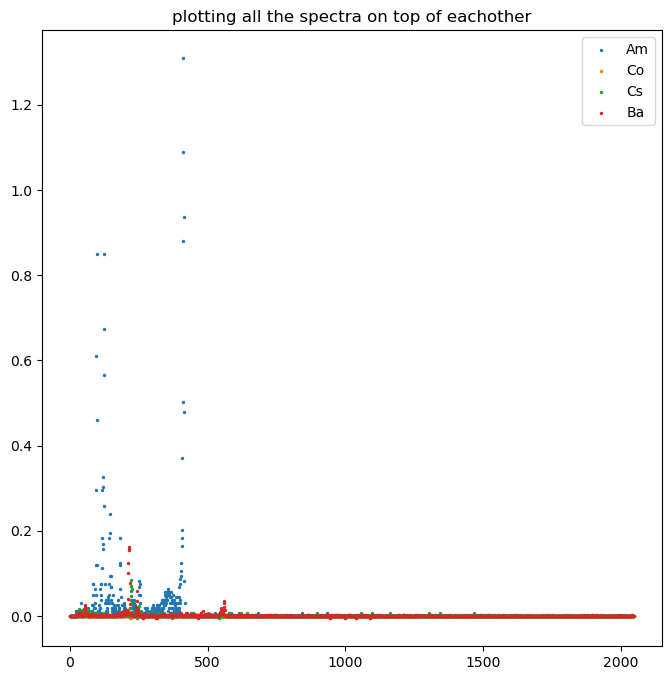

In [192]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title("plotting all the spectra on top of eachother")
ax.scatter(Am_sub_table["bins"], Am_sub_table["counts/sec"], s = 2, label = "Am")
ax.scatter(Co_sub_table["bins"], Co_sub_table["counts/sec"], s = 2, label = "Co")
ax.scatter(Cs_sub_table["bins"], Cs_sub_table["counts/sec"], s = 2, label = "Cs")
ax.scatter(Ba_sub_table["bins"], Ba_sub_table["counts/sec"], s = 2, label = "Ba")

ax.legend()
plt.show()

**Somethings fucked up with the CdTe detector, I'm gonna do the same procedure with the BGO data now tho:**

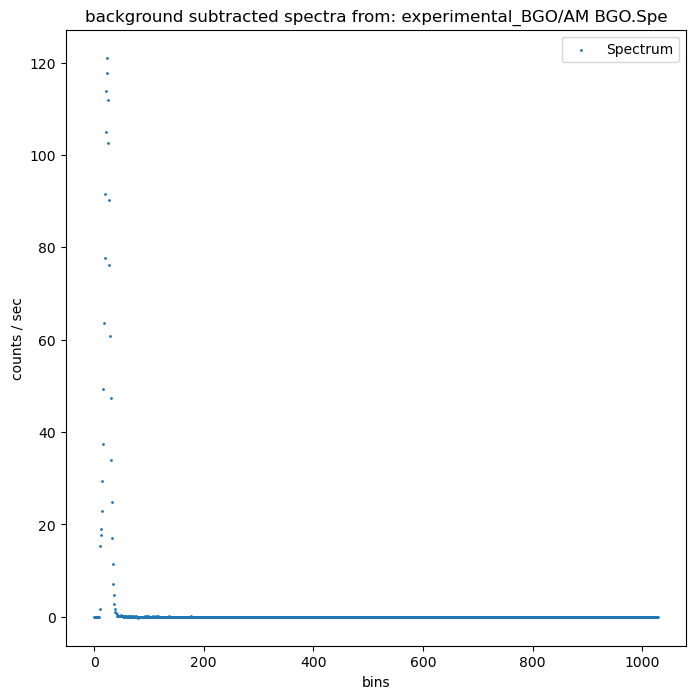

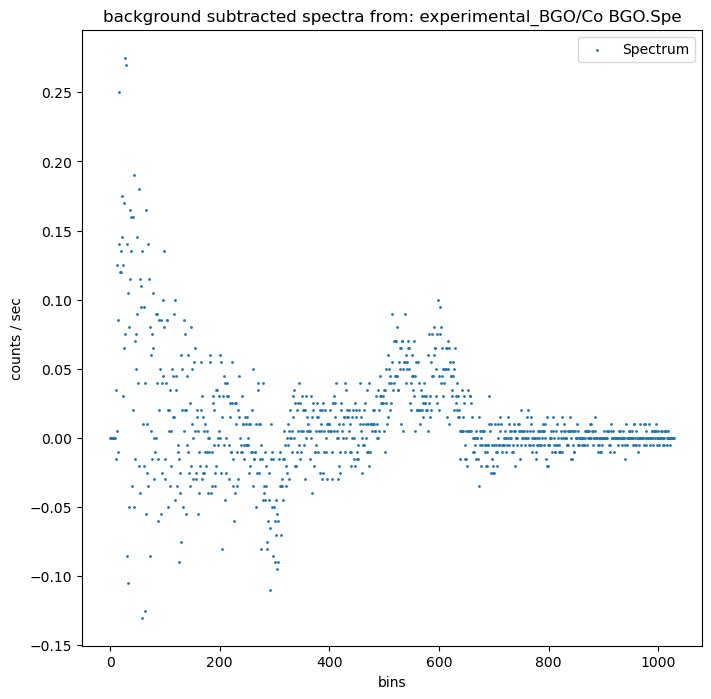

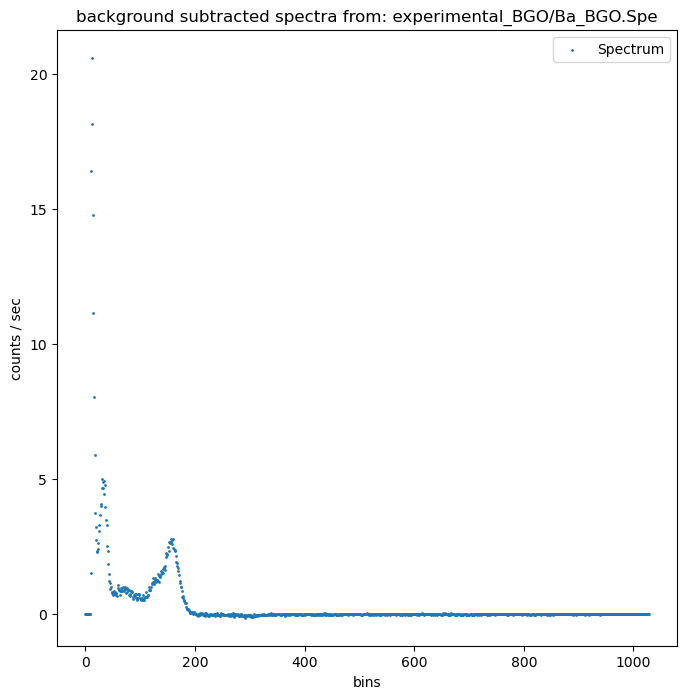

In [202]:
Am = "experimental_BGO/AM BGO.Spe"
#Cs = I DONT HAVE THE DATA RN
Co = "experimental_BGO/Co BGO.Spe"
Ba = "experimental_BGO/Ba_BGO.Spe"

bg = "experimental_BGO/Background_BGO.Spe"

Am_sub_table =  background_subtract(Am, bg)
#Cs_sub_table =  background_subtract(Cs, bg)
Co_sub_table =  background_subtract(Co, bg)
Ba_sub_table =  background_subtract(Ba, bg)

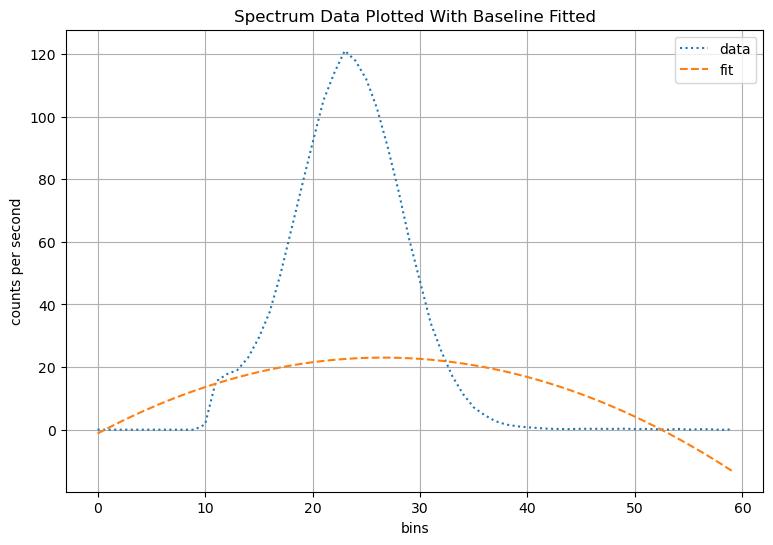

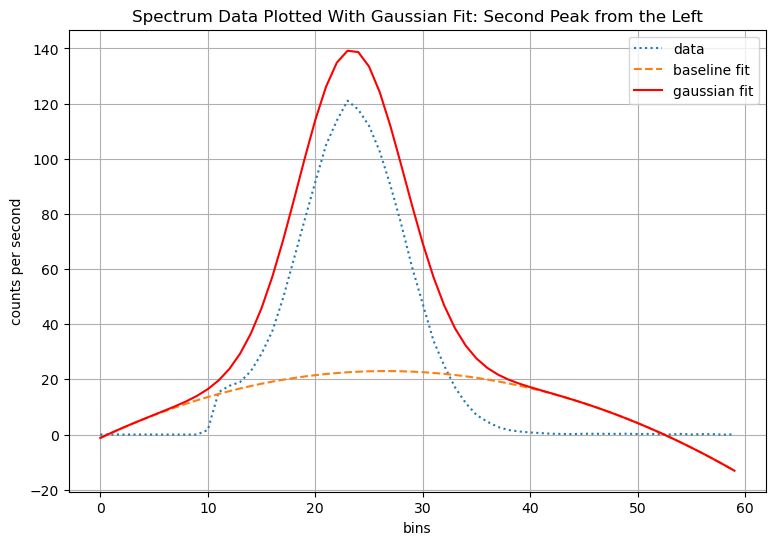

Parameters: 

Baseline Polynomial Fit: 
a = -0.0010175468565441362 +/- 0.0015555065573862733,
b = 0.037511974744788706 +/- 0.08872660832709063, 
c = 0.8184509335040748 +/- 0.8613345366502086
Gaussian Fit: 
mu0 = 23.35422173595694 +/- 0.04649714742699863,
sigma0 = -4.906335487574706 +/- 0.05982391093135362,
amp0 = 1437.5845148442324 +/- 22.652414973014242


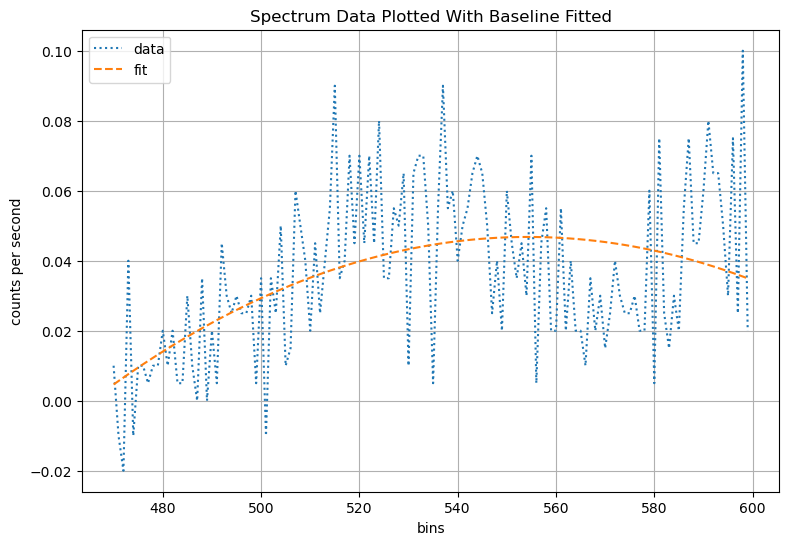

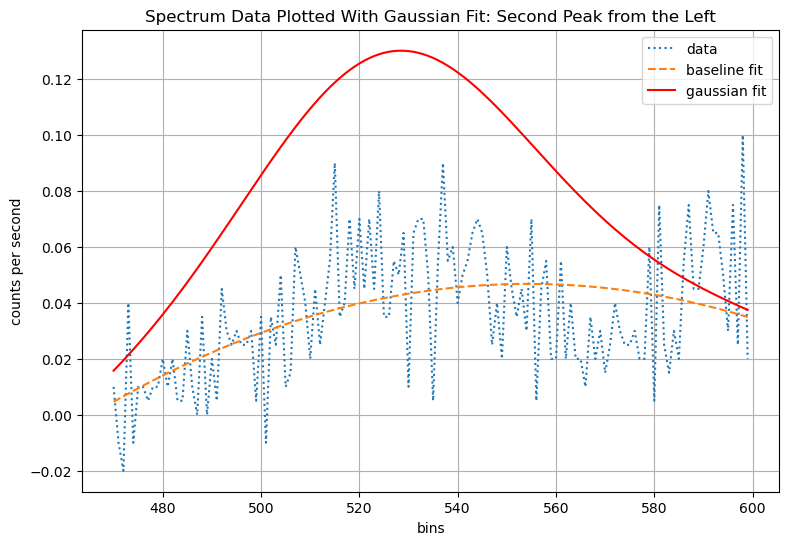

Parameters: 

Baseline Polynomial Fit: 
a = 1.4001386983523448e-05 +/- 1.09150208350166e-05,
b = -0.014487726403842228 +/- 0.011519672482130927, 
c = 3.7146617172808787 +/- 2.9837745377669598
Gaussian Fit: 
mu0 = 525.8388966685469 +/- 2.231788549259977,
sigma0 = 27.47350378980632 +/- 8.833499227919315,
amp0 = 6.041463086862878 +/- 5.696966297974966


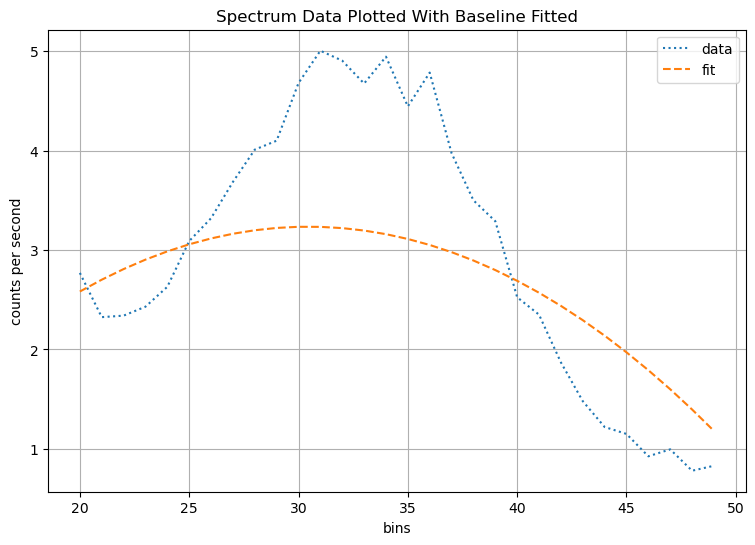

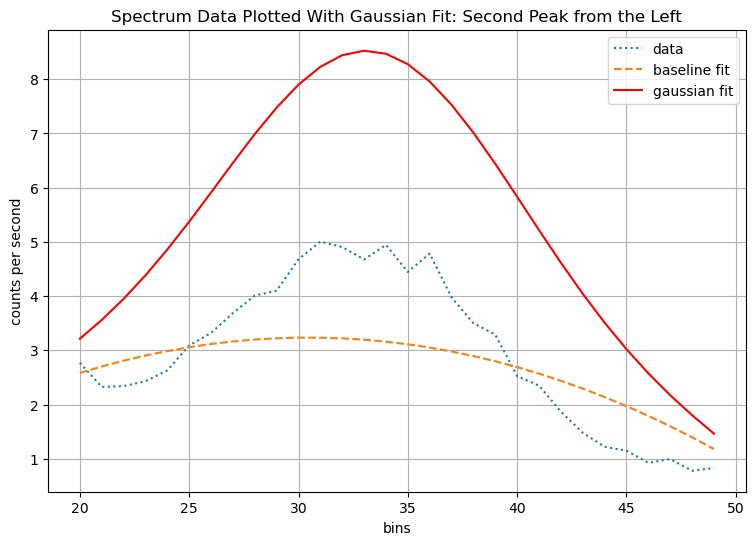

Parameters: 

Baseline Polynomial Fit: 
a = 0.00807751651977221 +/- 0.005561334919178278,
b = -0.5993206280617114 +/- 0.37388299673689457, 
c = 10.608203956833693 +/- 4.775996345977998
Gaussian Fit: 
mu0 = 33.34869560047921 +/- 0.15356349095041294,
sigma0 = 6.459958765333863 +/- 0.8496165535700061,
amp0 = 86.40838921939462 +/- 35.42034306636436


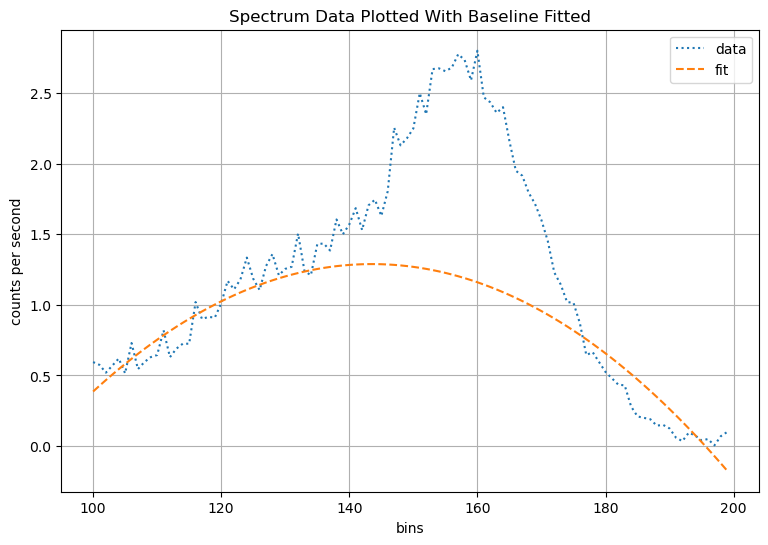

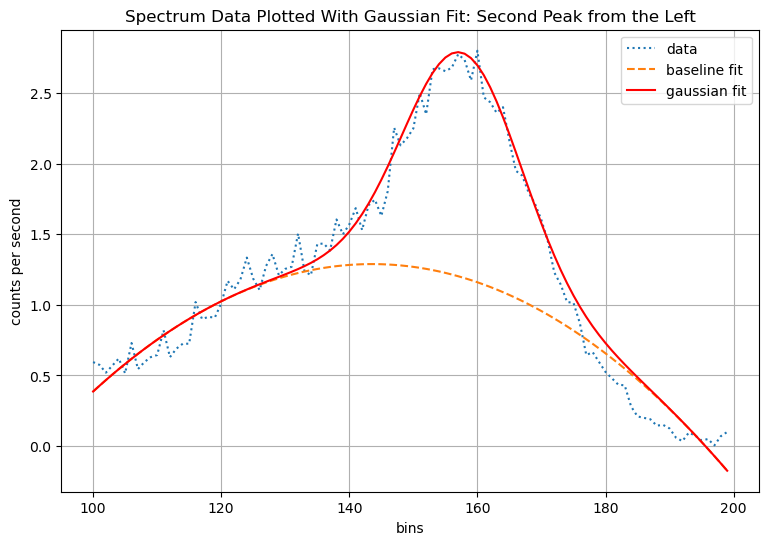

Parameters: 

Baseline Polynomial Fit: 
a = -0.00046331184578461373 +/- 2.7005399097625573e-05,
b = 0.13147422220910668 +/- 0.008217572830110684, 
c = -8.076859739502927 +/- 0.5890312381875991
Gaussian Fit: 
mu0 = 157.61740568261732 +/- 0.25842890404469465,
sigma0 = 9.018689876960504 +/- 0.35523782204688975,
amp0 = 35.96543035612024 +/- 1.9639164820591326


In [217]:
Am_peak = gauss_fitter(Am_sub_table, range(0,60))
Co_peak_1 = gauss_fitter(Co_sub_table, range(470, 600))
Ba_peak_1 = gauss_fitter(Ba_sub_table, range(20, 50))
Ba_peak_2 = gauss_fitter(Ba_sub_table, range(100,200))

In [218]:
BGO_table = {
    'channel': [Am_peak, Co_peak_1, Ba_peak_1, Ba_peak_2],
    'energy': [energies["Am"][0], energies["Co"][0], energies["Ba"][0], energies["Ba"][1]]
}

In [219]:
BGO = pd.DataFrame(BGO_table)
BGO.sort_values("channel")

,channel,energy
0,23.354222,59.5409
2,33.348696,80.9979
3,157.617406,356.0129
1,525.838897,1173.2280


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 4
    # variables        = 2
    chi-square         = 0.78117471
    reduced chi-square = 0.39058735
    Akaike info crit   = -2.53300328
    Bayesian info crit = -3.76041456
    R-squared          = 0.99999904
[[Variables]]
    slope:      2.21717690 +/- 0.00153370 (0.07%) (init = 1)
    intercept:  7.17894327 +/- 0.42212229 (5.88%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.6723


name,value,standard error,relative error,initial value,min,max,vary
slope,2.21717690,0.00153370,(0.07%),1.0,-inf,inf,True
intercept,7.17894327,0.42212229,(5.88%),0.0,-inf,inf,True


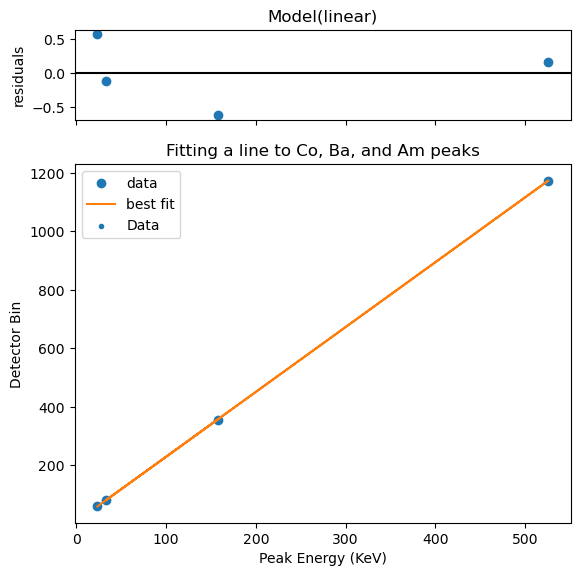

In [220]:
model_fit_and_plot(BGO_table['channel'], BGO_table['energy'], "Co, Ba, and Am peaks")